In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl

# Define transforms for CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0, 0, 0), (1, 1, 1))  # Normalize the images
])

# Load CIFAR-10 dataset
cifar10 = CIFAR10(root='../data', download=True, transform=transform)

C:\Users\korol\miniforge3\envs\sophius\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified


In [2]:
import sqlite3
import pandas as pd
from sophius.encode import Encoder

with sqlite3.connect('../data/models.db') as conn:
    df = pd.read_sql('SELECT * FROM conv_10_lin_3_epoch_50', conn)

model_id = 371

encoder = Encoder()
t = encoder.hash2model(df.loc[model_id, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)
model = t.instantiate_model(gpu=True)
model

Sequential(
  (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
  (1): LeakyReLU(negative_slope=0.001)
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): MaxPool2d(kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), dilation=(1, 1), ceil_mode=False)
  (5): ReLU()
  (6): AvgPool2d(kernel_size=(4, 4), stride=(2, 2), padding=(0, 0))
  (7): Conv2d(32, 96, kernel_size=(2, 2), stride=(2, 2))
  (8): PReLU(num_parameters=1)
  (9): MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (10): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): AvgPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=96, out_features=10, bias=True)
)

In [6]:
# Define the Lightning Module for Classification using nn.Sequential
class LitClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = torch.sum(torch.argmax(y_hat, dim=1) == y) / len(y)
        # self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss    

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [7]:
import torch
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader


# Preprocess and transfer dataset to GPU
def load_data_to_gpu(dataset):
    imgs, labels = zip(*dataset)
    imgs = torch.stack(imgs).to('cuda')  # Move images to GPU
    labels = torch.tensor(labels).to('cuda')  # Move labels to GPU
    return imgs, labels

# Load data to GPU
images, labels = load_data_to_gpu(cifar10)

# Create TensorDataset for DataLoader
full_dataset = TensorDataset(images, labels)

# Split dataset into training and validation sets
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Create DataLoader


In [11]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [13]:
import warnings
warnings.filterwarnings("ignore")

# Create model and trainer
litmodel = LitClassifier(model)
trainer = pl.Trainer(accelerator='gpu', max_epochs=10)

# Train the model
trainer.fit(litmodel, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 24.4 K
-------------------------------------
24.4 K    Trainable params
0         Non-trainable params
24.4 K    Total params
0.098     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 44/44 [00:01<00:00, 23.53it/s, loss=0.485, v_num=31]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 44/44 [00:01<00:00, 23.41it/s, loss=0.485, v_num=31]


# Comprare with custom train and gpu_loader

In [4]:
from sophius.train import train_on_gpu

res = train_on_gpu(model = model,  
                  loader = loader_gpu,
                  learning_rate=1e-3,
                  num_epoch = 10,
                  verbose = True)

Loss 35.945: 100%|██████████| 50/50 [01:17<00:00,  1.55s/it]

val_acc: 0.692, train_acc: 0.739


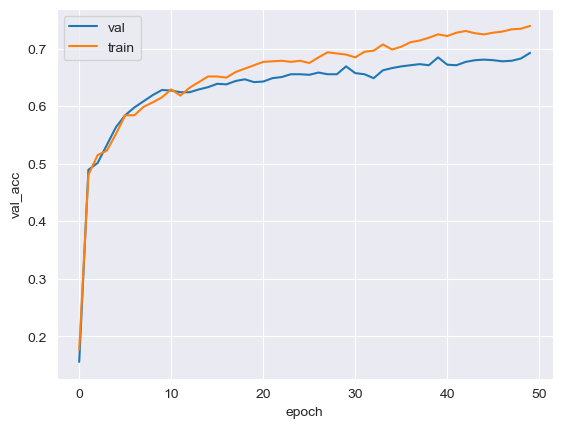

In [5]:
import seaborn as sns

sns.lineplot(res, x = 'epoch', y = 'val_acc', label = 'val')
sns.lineplot(res, x = 'epoch', y = 'train_acc', label = 'train');

In [26]:
res = train_on_gpu(model = model,  
                   loader = loader_gpu,
                   learning_rate=1e-2,
                   gamma=0.3,
                   milestones=[20, 30, 40],                
                   num_epoch = 50,
                   verbose = True)

sns.lineplot(res, x = 'epoch', y = 'val_acc', label = 'val')
sns.lineplot(res, x = 'epoch', y = 'train_acc', label = 'train');

Loss 65.263:  12%|█▏        | 6/50 [01:09<08:24, 11.47s/it]

KeyboardInterrupt: 